In [1]:
from shapely.geometry import Polygon, Point
import itertools
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio import mask
from rasterio.plot import show
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import torch.nn as nn
import numpy as np
import shapely.wkt as wkt
import torch
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from tqdm import tqdm
from skimage.measure import label, regionprops
import os
import dask
import time
import gc
import re
from rioxarray.exceptions import NoDataInBounds
from rioxarray.merge import merge_arrays
from scipy.interpolate import NearestNDInterpolator

In [2]:
import distributed
dask.config.set({"distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_": 0})
dask.config.set(scheduler='processes')

In [3]:
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))

print(os.environ["MALLOC_TRIM_THRESHOLD_"])

#os.environ["MALLOC_TRIM_THRESHOLD_"] = '0'

0


In [4]:
import xarray as xr
import rioxarray as riox
from xrspatial import convolution, focal, hillshade
from skimage.transform import resize
from dask.distributed import LocalCluster, Client

In [5]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
client = Client(cluster)
client.amm.start()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34861,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:39587,Total threads: 2
Dashboard: http://127.0.0.1:37781/status,Memory: 1.94 GiB
Nanny: tcp://127.0.0.1:43255,


In [6]:
# create function to normalize all data in range 0-1
def normalize_fn(image, image_suffix, stats_dict):
    if image_suffix in stats_dict.keys():
        min_tmp = stats_dict[image_suffix]['min']
        max_tmp = stats_dict[image_suffix]['max']
    else:
        # normalize to individual image if min/max stats not specified in dictionary
        min_tmp = np.min(image)
        max_tmp = np.max(image)
    return (image - min_tmp) / (max_tmp - min_tmp)

def calc_tpi(dtm, inner_r, outer_r, interpolate=True, values=True, bounds=(-2.0, 3.0), fillna=None):
    cellsize_x, cellsize_y = convolution.calc_cellsize(dtm)
    kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_r, inner_r)
    tpi = dtm - focal.apply(dtm, kernel)
    tpi = tpi.rio.write_nodata(-9999.)
    tpi = tpi.where((tpi > bounds[0]) & (tpi < bounds[1]))
    if interpolate:
        if tpi.isnull().any().values:
            tpi = tpi.rio.interpolate_na(method='nearest')
    if fillna is not None:
        tpi = tpi.fillna(fillna)
    if values:
        return tpi.values
    else:
        return tpi

def calc_ndvi(ms, interpolate=True, values=True, fillna=None):
    ndvi = (ms.sel(band=4).astype('float32') - ms.sel(band=3).astype('float32'))\
            / (ms.sel(band=4).astype('float32') + ms.sel(band=3).astype('float32'))
    ndvi = ndvi.rio.write_nodata(-9999.)
    ndvi = ndvi.where(ndvi != -9999.)
    if interpolate:
        if ndvi.isnull().any().values:
            ndvi = ndvi.rio.interpolate_na(method='nearest')
    if fillna is not None:
        ndvi = ndvi.fillna(fillna)
    if values:
        return ndvi.values
    else:
        return ndvi

In [7]:
from collections import namedtuple
from operator import mul

try:
    reduce = reduce
except NameError:
    from functools import reduce # py3k

Info = namedtuple('Info', 'start height')

def max_size(mat, value=0):
    """Find height, width of the largest rectangle containing all `value`'s.
    For each row solve "Largest Rectangle in a Histrogram" problem [1]:
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    it = iter(mat)
    hist = [(el==value) for el in next(it, [])]
    max_size = max_rectangle_size(hist)
    for row in it:
        hist = [(1+h) if el == value else 0 for h, el in zip(hist, row)]
        max_size = max(max_size, max_rectangle_size(hist), key=area)
    return max_size

def max_rectangle_size(histogram):
    """Find height, width of the largest rectangle that fits entirely under
    the histogram.
    >>> f = max_rectangle_size
    >>> f([5,3,1])
    (3, 2)
    >>> f([1,3,5])
    (3, 2)
    >>> f([3,1,5])
    (5, 1)
    >>> f([4,8,3,2,0])
    (3, 3)
    >>> f([4,8,3,1,1,0])
    (3, 3)
    >>> f([1,2,1])
    (1, 3)
    Algorithm is "Linear search using a stack of incomplete subproblems" [1].
    [1]: http://blog.csdn.net/arbuckle/archive/2006/05/06/710988.aspx
    """
    stack = []
    top = lambda: stack[-1]
    max_size = (0, 0) # height, width of the largest rectangle
    pos = 0 # current position in the histogram
    for pos, height in enumerate(histogram):
        start = pos # position where rectangle starts
        while True:
            if not stack or height > top().height:
                stack.append(Info(start, height)) # push
            elif stack and height < top().height:
                max_size = max(max_size, (top().height, (pos - top().start)),
                               key=area)
                start, _ = stack.pop()
                continue
            break # height == top().height goes here

    pos += 1
    for start, height in stack:
        max_size = max(max_size, (height, (pos - start)), key=area)

    return max_size

def area(size):
    return reduce(mul, size)

In [8]:
outDIR = './cnn_pred_results/'
if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [9]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['burrow']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda' #'cuda'# 'cpu'# 
model_fnl = 'deeplabplus'
res_fnl = 5
inputs_fnl = ['rgb', 'tpi', 'ndvi'] 
preprocess = True
prob_thresh = 0.5

In [10]:
size_dict = {
    2: {'tile_size': 256,
        'buff_size': 64},
    5: {'tile_size': 192,
        'buff_size': 48},
    10: {'tile_size': 128,
         'buff_size': 32},
    15: {'tile_size': 96,
         'buff_size': 16},
    30: {'tile_size': 64,
         'buff_size': 16}
}

In [11]:
past_subset = None
#past_subset = ['22W']

baseDIR = '/mnt/d/'

img_f_dict = {
    '5W': {
        'rgb': [os.path.join(baseDIR, '202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_ortho.tif')],
        'ms': [os.path.join(baseDIR, '202109/outputs/202109_5W_MS/CPER_202109_5W_MS_ortho.tif')],
        'dsm': [os.path.join(baseDIR, '202109/outputs/202109_5W_RGB/CPER_202109_5W_RGB_dsm.tif')]
    },
    '29-30': {
        'rgb': [os.path.join(baseDIR, '202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_ortho.tif')],
        'ms': [os.path.join(baseDIR, '202109/outputs/202109_29_30_MS/CPER_202109_29_30_North_MS_ortho.tif'),
              os.path.join(baseDIR, '202109/outputs/202109_29_30_MS/CPER_202109_29_30_South_MS_ortho.tif')],
        'dsm': [os.path.join(baseDIR, '202109/outputs/202109_29_30_RGB/CPER_202109_29_30_RGB_DSM.tif')]
    },
    '22W': {
        'rgb': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif')],
        'ms': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif')],
        'dsm': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif'),
                os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif')]
    },
    '22E': {
        'rgb': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_ortho.tif')],
        'ms': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_MS_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_MS_ortho.tif')],
        'dsm': [os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight1_RGB_DSM.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight2_RGB_DSM.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_22EW/CPER_202109_22EW_Flight3_RGB_DSM.tif')]
    },
    'CN': {
        'rgb': [os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight2_202109_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight3_202109_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight4_202109_RGB_ortho.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/Orthos/CPER_CN_Flight5_202109_RGB_ortho.tif')],
        'ms': [os.path.join(baseDIR, '202109/outputs/202109_CN_MS/CPER_202109_CN_Flight2_MS_ortho.tif'),
              os.path.join(baseDIR, '202109/outputs/202109_CN_MS/CPER_202109_CN_Flight3_MS_ortho.tif'),
              os.path.join(baseDIR, '202109/outputs/202109_CN_MS/CPER_202109_CN_Flight4_MS_ortho.tif'),],
        'dsm': [os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight2_202109_RGB_DSM.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight3_202109_RGB_DSM.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight4_202109_RGB_DSM.tif'),
               os.path.join(baseDIR, '202109/outputs/202109_CN_RGB/DSMs/CPER_CN_Flight5_202109_RGB_DSM.tif')]
    }
}

if past_subset is not None:
    img_f_dict_tmp = img_f_dict.copy()
    img_f_dict = {}
    for k in img_f_dict_tmp:
         if k in past_subset:
                img_f_dict[k] = img_f_dict_tmp[k]

cper_f = '/mnt/c/Users/TBGPEA-Sean/Desktop/Pdogs_UAS/cper_pdog_pastures_2017_clip.shp'

In [12]:
full_buff_size = 10
full_tile_size = 150
tile_size = size_dict[res_fnl]['tile_size']
buff_size = size_dict[res_fnl]['buff_size']
chunk_size = 250
buff_size_m = np.ceil(buff_size * res_fnl * 0.01)

In [13]:
# load best saved checkpoint
if res_fnl == 2:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '.pth')
else:
    best_model = torch.load('./cnn_results_' + model_fnl + '_' + str(res_fnl) + 'cm/best_model_' + '_'.join(inputs_fnl) + '_' + str(res_fnl) + 'cm.pth')

if DEVICE == 'cpu':
    best_model = best_model.cpu()
best_model.eval()

# load the image stats from the training data
df_image_stats = pd.read_csv('./_utils/image_stats_2cm.csv').set_index('stat')

# convert image stats dictionary to dataframe
image_stats = {i: {'min': df_image_stats.loc['min', i],
                   'max': df_image_stats.loc['max', i]} for i in df_image_stats.columns}

In [ ]:
cper_gdf = gpd.read_file(cper_f)

for pasture in tqdm(img_f_dict):
    print('\n\n----------\nPasture: ' + pasture)

    # get the bounding box of the pasture
    past_bbox = cper_gdf[cper_gdf['Past_Name_'] == pasture].buffer(
        full_buff_size).bounds.apply(lambda x: int(x))

    total_bounds = {'xmin': past_bbox['minx'],
                    'xmax': past_bbox['maxx'],
                    'ymin': past_bbox['miny'],
                    'ymax': past_bbox['maxy']}

    n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
    n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))

    outSHP = os.path.join(outDIR, 'burrow_pts_pred_' + '_'.join([pasture] + inputs_fnl + [str(res_fnl)]) + 'cm.shp')
    if os.path.exists(outSHP):
        gdf_out = gpd.read_file(outSHP)
        r_ct_pred = len(gdf_out)
        rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
    elif os.path.exists(re.sub('.shp', '.csv', outSHP)):
        gdf_out = pd.read_csv(re.sub('.shp', '.csv', outSHP))
        r_ct_pred = len(gdf_out)
        rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
    else:
        r_ct_pred = 0
        gdf_out = gpd.GeoDataFrame()
        rc_completed = []
    tile_ct = 0
    for full_r in range(n_row_tiles):
        print('running row: ' + str(full_r + 1) + ' of ' + str(n_row_tiles))
        for full_c in tqdm(range(n_col_tiles)):
            if len(client.cluster.workers) < 8:
                client.shutdown()
                client.close()
                cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                client = Client(cluster)
                client.amm.start()
            if '_'.join([str(full_r), str(full_c)]) in rc_completed:
                #print('skipping row/column combination, already in shapefile!')
                continue
            else:
                try:
                    t0=time.time()

                    ll_tile = [full_c * full_tile_size + total_bounds['xmin'],
                               full_r * full_tile_size + total_bounds['ymin']]
                    ul_tile = [ll_tile[0], ll_tile[1] + full_tile_size]
                    ur_tile = [x + full_tile_size for x in ll_tile]
                    lr_tile = [ll_tile[0] + full_tile_size, ll_tile[1]]
                    tile_poly = Polygon([ll_tile, ul_tile, ur_tile, lr_tile])

                    ll = [full_c * full_tile_size + total_bounds['xmin'] - buff_size_m,
                          full_r * full_tile_size + total_bounds['ymin'] - buff_size_m]
                    ul = [ll[0], ll[1] + full_tile_size + (buff_size_m * 2.0)]
                    ur = [x + full_tile_size + (buff_size_m * 2.0) for x in ll]
                    lr = [ll[0] + full_tile_size + (buff_size_m * 2.0), ll[1]]

                    image_dict = {}
                    newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
                    newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))
                    if 'rgb' in inputs_fnl:
                        print('getting RGB')
                        t1=time.time()

                        rgb_xr_list = []
                        print('creating RGB list')
                        for rgb_f in img_f_dict[pasture]['rgb']:
                            with riox.open_rasterio(rgb_f, masked=True, cache=False) as rgb_src:
                                rgb_xr_list.append(rgb_src.sel(band=slice(0, 3),
                                                               x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True).load())
                        print('masking')
                        rgb_xr_list = [x for x in rgb_xr_list if not any([s == 0 for s in x.shape])]
                        rgb_xr_list = [x.where(x != 255) for x in rgb_xr_list if not x.where(x != 255).isnull().all().values]
                        rgb_null_ct = [x.isnull().sum().values.item() for x in rgb_xr_list]
                        rgb_nonull_mask = [x==0 for x in rgb_null_ct]
                        if any(rgb_nonull_mask):
                            rgb_xr_list = [rgb_xr_list[np.argsort(rgb_null_ct)[0]]]
                        else:
                            rgb_xr_list = [rgb_xr_list[i] for i in np.argsort(rgb_null_ct)]
                        print('writing nodata')
                        rgb_xr_list = [x.rio.write_nodata(-9999.) for x in rgb_xr_list]

                        print('merging')
                        rgb_xr = merge_arrays(rgb_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='first',
                                              nodata=-9999.)
                        print('masking')
                        rgb_xr = rgb_xr.where(rgb_xr != -9999.)
                        image_dict['rgb'] = rgb_xr.values
                        #rgb_xr.close()
                        t2=time.time()
                        print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
                        t1 = time.time()
                        print('getting DSM')
                        dsm_xr_list = []
                        for dsm_f in img_f_dict[pasture]['dsm']:
                            with riox.open_rasterio(dsm_f, masked=True, cache=False) as dsm_src:
                                dsm_xr_list.append(dsm_src.sel(x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True).load())

                        dsm_xr_list = [x for x in dsm_xr_list if not any([s == 0 for s in x.shape])]
                        dsm_xr_list = [x.where(x > 0).squeeze() for x in dsm_xr_list if not x.where(x > 0).isnull().all().values]
                        dsm_null_ct = [x.isnull().sum().values.item() for x in dsm_xr_list]
                        dsm_nonull_mask = [x==0 for x in dsm_null_ct]
                        if any(dsm_nonull_mask):
                            dsm_xr_list = [dsm_xr_list[np.argsort(dsm_null_ct)[0]]]
                        else:
                            dsm_xr_list = [dsm_xr_list[i] for i in np.argsort(dsm_null_ct)]
                        dsm_xr_list = [x.rio.write_nodata(-9999.) for x in dsm_xr_list]

                        dsm_xr = merge_arrays(dsm_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='first',
                                              nodata=-9999.)

                        dsm_xr = dsm_xr.where(dsm_xr != -9999.)

                        if 'dsm' in inputs_fnl:
                            image_dict['dsm'] = dsm_xr.values
                        #dsm_xr.close()
                        t2=time.time()
                        print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'tpi' in inputs_fnl: 
                        t1 = time.time()
                        print('computing TPI')
                        # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
                        outer_radius = "0.75m"
                        inner_radius = "0.25m"
                        image_dict['tpi'] = calc_tpi(dsm_xr.chunk({'x': chunk_size,
                                                                   'y': chunk_size}), 
                                                     inner_r=inner_radius, 
                                                     outer_r=outer_radius, 
                                                     interpolate=False,
                                                     values=True)
                        #dsm_xr.close()
                        t2=time.time()
                        print('... completed in', round(t2 - t1, 1), 'secs')
                    if 'ndvi' in inputs_fnl:
                        t1 = time.time()
                        print('computing NDVI')
                        ms_xr_list = []
                        for ms_f in img_f_dict[pasture]['ms']:
                            with riox.open_rasterio(ms_f, masked=True, cache=False) as ms_src:
                                ms_xr_list.append(ms_src.sel(band=[4, 3],
                                                               x=slice(ll[0], lr[0]),
                                                               y=slice(ul[1], ll[1]), 
                                                               drop=True).load())

                        ms_xr_list = [x for x in ms_xr_list if not any([s == 0 for s in x.shape])]
                        ms_xr_list = [x.where(x != 65535) for x in ms_xr_list if not x.where(x != 65535).isnull().all().values]
                        ms_null_ct = [x.isnull().sum().values.item() for x in ms_xr_list]
                        ms_nonull_mask = [x==0 for x in ms_null_ct]
                        if any(ms_nonull_mask):
                            ms_xr_list = [ms_xr_list[np.argsort(ms_null_ct)[0]]]
                        else:
                            ms_xr_list = [ms_xr_list[i] for i in np.argsort(ms_null_ct)]
                        ms_xr_list = [x.rio.write_nodata(-9999.) for x in ms_xr_list]

                        ms_xr = merge_arrays(ms_xr_list,
                                              bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                              res=res_fnl*0.01, 
                                              crs=rio.CRS.from_epsg(32613),
                                              method='first',
                                              nodata=-9999.)

                        ms_xr = ms_xr.where(ms_xr != -9999.)
                        image_dict['ndvi'] = calc_ndvi(ms_xr, values=True, interpolate=False)
                        #ms_xr.close()
                        t2=time.time()
                        print('... completed in', round(t2 - t1, 1), 'secs')

                    if 'rgb' in image_dict:
                        tshape = image_dict['rgb'].shape[1:]
                    else:
                        tshape = image_dict[inputs_fnl[0]].shape

                    n_row_chunks = int(np.ceil(tshape[0]/tile_size))
                    n_col_chunks = int(np.ceil(tshape[1]/tile_size))

                    pr_mask = np.empty(tshape)
                    t1 = time.time()
                    print('predicting binary burrow image')
                    for r in range(n_row_chunks):
                        if (r + 1) * tile_size > tshape[0]:
                            r_min = tshape[0] - tile_size
                            r_max = tshape[0]
                            r_max_comp = tshape[0]
                        elif (r + 1) * tile_size + buff_size > tshape[0]:
                            r_min = r * tile_size
                            r_max = (r + 1) * tile_size
                            r_max_comp = r_max
                        else:
                            r_min = r * tile_size
                            r_max = (r + 1) * tile_size
                            r_max_comp = r_max + buff_size
                        for c in range(n_col_chunks):
                            image_sub_dict = {}
                            if (c + 1) * tile_size > tshape[1]:
                                c_min = tshape[1] - tile_size
                                c_max = tshape[1]
                                c_max_comp = tshape[1]
                            elif (c + 1) * tile_size + buff_size > tshape[1]:
                                c_min = c * tile_size
                                c_max = (c + 1) * tile_size
                                c_max_comp = c_max
                            else:
                                c_min = c * tile_size
                                c_max = (c + 1) * tile_size
                                c_max_comp = c_max + buff_size
                            for k in image_dict:
                                if k == 'rgb':
                                    image_sub_dict[k] = image_dict[k][:,
                                                                      slice(max(0, r_min-buff_size), r_max_comp),
                                                                      slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                else:
                                    image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                                      slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                                if len(image_sub_dict[k].shape) == 2:
                                    image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                                if np.all(np.isnan(image_sub_dict[k])):
                                    continue
                                elif np.any(np.isnan(image_sub_dict[k])):
                                    for i in range(image_sub_dict[k].shape[0]):
                                        if np.any(np.isnan(image_sub_dict[k][i, :, :])):
                                            data = image_sub_dict[k][i, :, :].copy()
                                            mask = np.where(~np.isnan(data))
                                            interp = NearestNDInterpolator(np.transpose(mask), data[mask])
                                            image_sub_dict[k][i, :, :] = interp(*np.indices(data.shape))
                                            del data, mask, interp
    
                            if np.any([np.all(np.isnan(image_sub_dict[k])) for k in image_sub_dict]):
                                pr_mask[r_min:r_max, c_min:c_max] = np.nan
                                continue
                            else:
                                if preprocess:
                                    for i in image_sub_dict:
                                        image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                                image_list = [image_sub_dict[i] for i in inputs_fnl]
                                image_out = np.concatenate(image_list, axis=0)
                                x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                                if type(best_model) == nn.DataParallel:
                                    pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                                    buff_r_max = buff_size * int(r_max+buff_size <= tshape[0])
                                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                                    buff_c_max = buff_size * int(c_max+buff_size <= tshape[1])
                                    if pred_tmp.shape[1] > tile_size:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                    else:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                                else:
                                    pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                                    buff_r_min = buff_size * int(r_min-buff_size > 0)
                                    buff_r_max = buff_size * int(r_max+buff_size <= tshape[0])
                                    buff_c_min = buff_size * int(c_min-buff_size > 0)
                                    buff_c_max = buff_size * int(c_max+buff_size <= tshape[1])
                                    if pred_tmp.shape[1] > tile_size:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                                     buff_c_min:pred_tmp.shape[1]-buff_c_max]
                                    else:
                                        pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                    t2=time.time()
                    print('... completed in', round(t2 - t1, 1), 'secs')
                    t1 = time.time()
                    print('getting burrow locations')
                    if np.all(pr_mask == 0):
                        gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                        gdf_tmp['tile_row'] = full_r
                        gdf_tmp['tile_col'] =  full_c
                        gdf_tmp['tile_size'] = full_tile_size
                        gdf_out = pd.concat([gdf_out, gdf_tmp])
                        del gdf_tmp
                        r_ct_pred += 1
                    else:
                        pr_labels = label(pr_mask)
                        pr_regions = regionprops(pr_labels)
                        pr_regions = [r for r in pr_regions if (r.area*(res_fnl/100)**2 > 0.05) & (r.area*(res_fnl/100)**2 < 5.0)]
                        if len(pr_regions) == 0:
                            #print('no burrow locations found!')
                            gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                            gdf_tmp['tile_row'] = full_r
                            gdf_tmp['tile_col'] =  full_c
                            gdf_tmp['tile_size'] = full_tile_size
                            gdf_out = pd.concat([gdf_out, gdf_tmp])
                            del gdf_tmp
                            r_ct_pred += 1
                        else:
                            r_ct_tile = 0
                            for r in pr_regions:
                                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, 
                                                                             index=[r_ct_pred]), 
                                                           geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                            ul[1] - r.centroid[0]*(res_fnl*0.01)])], 
                                                           crs='EPSG:32613')
                                if gdf_tmp.geometry.within(tile_poly).values[0]:
                                    gdf_tmp['tile_row'] = full_r
                                    gdf_tmp['tile_col'] =  full_c
                                    gdf_tmp['tile_size'] = full_tile_size
                                    gdf_out = pd.concat([gdf_out, gdf_tmp])
                                    r_ct_tile += 1
                                if type(gdf_out) is pd.core.frame.DataFrame:
                                    gdf_out = gpd.GeoDataFrame(gdf_out, geometry = gdf_out['geometry'])
                                del gdf_tmp
                                r_ct_pred += 1
                            if r_ct_tile == 0:
                                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                                gdf_tmp['tile_row'] = full_r
                                gdf_tmp['tile_col'] =  full_c
                                gdf_tmp['tile_size'] = full_tile_size
                                gdf_out = pd.concat([gdf_out, gdf_tmp])
                                del gdf_tmp
                                r_ct_pred += 1
                        t2=time.time()
                        print('... completed in', round(t2 - t1, 1), 'secs')
                    if type(gdf_out) is pd.core.frame.DataFrame:
                        gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
                    else:
                        gdf_out.to_file(outSHP)
                    try:
                        del pr_mask, pred_tmp, pr_labels, pr_regions, image_dict, image_sub_dict, image_list, image_out
                    except NameError:
                        pass
                    gc.collect()
                    client.run(gc.collect)
                    client.run(trim_memory)
                    if (tile_ct > 0) & (tile_ct % 15 == 0):
                        try:
                            client.restart(timeout=9)
                            time.sleep(10)
                        except TimeoutError:
                            client.shutdown()
                            client.close()
                            cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                            client = Client(cluster)
                            client.amm.start()

                    #client.restart()
                except NoDataInBounds:
                    gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                    gdf_tmp['tile_row'] = full_r
                    gdf_tmp['tile_col'] =  full_c
                    gdf_tmp['tile_size'] = full_tile_size
                    gdf_out = pd.concat([gdf_out, gdf_tmp])
                    del gdf_tmp
                    r_ct_pred += 1
                    if type(gdf_out) is pd.core.frame.DataFrame:
                        gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
                    else:
                        gdf_out.to_file(outSHP)
                    continue
                    #print('No data in bounds. Skipping row/column.')
            tile_ct += 1
        #if not '_'.join([str(full_r), str(full_c)]) in rc_completed:
    print('Pasture-group finished!')
    try:
        client.restart(timeout=9)
        time.sleep(10)
    except TimeoutError:
        client.shutdown()
        client.close()
        cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
        client = Client(cluster)
        client.amm.start()


  0%|                                                                                             | 0/5 [00:00<?, ?it/s]



----------
Pasture: 5W
running row: 1 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.8 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 9.9 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 8.2 secs
getting burrow locations
... completed in 0.7 secs



 17%|██████████████▏                                                                      | 1/6 [00:30<02:34, 30.81s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 7.2 secs
getting burrow locations
... completed in 0.7 secs



 33%|████████████████████████████▎                                                        | 2/6 [00:56<01:51, 27.77s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 6.1 secs
getting burrow locations
... completed in 0.8 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:21<01:19, 26.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.6 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 4.8 secs
getting burrow locations
... completed in 1.0 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:46<00:51, 25.77s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.7 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 4.8 secs
getting burrow locations
... completed in 0.8 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:09<00:25, 25.08s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 9.6 secs
getting burrow locations
... completed in 0.8 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:39<00:00, 26.67s/it]


running row: 2 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 4.4 secs
getting burrow locations
... completed in 0.5 secs



 17%|██████████████▏                                                                      | 1/6 [00:24<02:02, 24.50s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.2 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 1.3 secs
predicting binary burrow image
... completed in 7.7 secs
getting burrow locations
... completed in 1.1 secs



 33%|████████████████████████████▎                                                        | 2/6 [00:52<01:46, 26.75s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.8 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.8 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:20<01:21, 27.13s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 11.0 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 5.4 secs
getting burrow locations
... completed in 1.1 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:49<00:55, 27.75s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 4.7 secs
getting burrow locations
... completed in 1.0 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:16<00:27, 27.55s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 11.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 7.9 secs
getting burrow locations
... completed in 0.9 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:47<00:00, 27.88s/it]


running row: 3 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 3.2 secs
getting burrow locations
... completed in 0.4 secs



 17%|██████████████▏                                                                      | 1/6 [00:25<02:06, 25.24s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 7.4 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.4 secs



 33%|████████████████████████████▎                                                        | 2/6 [00:55<01:52, 28.17s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.7 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:22<01:23, 27.84s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.2 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 3.7 secs
getting burrow locations
... completed in 0.8 secs


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds

 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:09<01:10, 35.30s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 10.9 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 3.7 secs
getting burrow locations
... completed in 1.3 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:41<00:34, 34.21s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 1.1 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:13<00:00, 32.20s/it]


running row: 4 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.8 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 3.7 secs
getting burrow locations
... completed in 0.3 secs



 17%|██████████████▏                                                                      | 1/6 [00:27<02:19, 27.90s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 11.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 7.5 secs
getting burrow locations
... completed in 0.2 secs



 33%|████████████████████████████▎                                                        | 2/6 [00:59<02:01, 30.28s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.3 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:27<01:27, 29.30s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 11.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 3.2 secs
getting burrow locations
... completed in 0.7 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:55<00:57, 28.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 3.9 secs
getting burrow locations
... completed in 0.7 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:21<00:27, 27.79s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.5 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.2 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 6.2 secs
getting burrow locations
... completed in 0.9 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:52<00:00, 28.77s/it]


running row: 5 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 5.4 secs
getting burrow locations
... completed in 0.2 secs



 17%|██████████████▏                                                                      | 1/6 [00:28<02:22, 28.45s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 8.0 secs
getting burrow locations
... completed in 0.2 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:00<02:01, 30.48s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.2 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:30<01:31, 30.39s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.4 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:59<00:59, 29.89s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.9 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 5.3 secs
getting burrow locations
... completed in 0.7 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:29<00:29, 29.80s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 8.5 secs
getting burrow locations
... completed in 1.2 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:02<00:00, 30.49s/it]


running row: 6 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 3.5 secs
getting burrow locations
... completed in 0.2 secs



 17%|██████████████▏                                                                      | 1/6 [00:40<03:20, 40.01s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 10.7 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.2 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:14<02:27, 36.91s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.9 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 5.9 secs
getting burrow locations
... completed in 0.3 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:44<01:41, 33.67s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.6 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 7.2 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 3.9 secs
getting burrow locations
... completed in 0.3 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:13<01:03, 31.84s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 4.2 secs
getting burrow locations
... completed in 0.5 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:42<00:30, 30.76s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 6.8 secs
getting burrow locations
... completed in 0.6 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:13<00:00, 32.27s/it]


running row: 7 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.5 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs



 17%|██████████████▏                                                                      | 1/6 [00:28<02:24, 28.98s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.6 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 7.8 secs
getting burrow locations
... completed in 0.2 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:00<02:02, 30.50s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 5.8 secs
getting burrow locations
... completed in 0.2 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:30<01:30, 30.03s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 4.8 secs
getting burrow locations
... completed in 0.6 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [01:59<00:59, 29.70s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 4.2 secs
getting burrow locations
... completed in 0.7 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:27<00:29, 29.23s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.4 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:58<00:00, 29.72s/it]


running row: 8 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs



 17%|██████████████▏                                                                      | 1/6 [00:28<02:22, 28.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.6 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 9.2 secs
getting burrow locations
... completed in 0.5 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:01<02:05, 31.36s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.5 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 6.7 secs
getting burrow locations
... completed in 0.5 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:32<01:32, 30.83s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.7 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 8.0 secs
getting burrow locations
... completed in 0.6 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:16<01:12, 36.39s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 10.2 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.6 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:51<00:35, 35.65s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 9.0 secs
getting burrow locations
... completed in 0.6 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:25<00:00, 34.33s/it]


running row: 9 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.7 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 5.8 secs
getting burrow locations
... completed in 0.1 secs



 17%|██████████████▏                                                                      | 1/6 [00:30<02:30, 30.19s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 8.7 secs
getting burrow locations
... completed in 0.3 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:02<02:06, 31.66s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 7.5 secs
getting burrow locations
... completed in 0.8 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:34<01:35, 31.79s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 5.5 secs
getting burrow locations
... completed in 0.6 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:05<01:03, 31.51s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.8 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:36<00:31, 31.03s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 8.4 secs
getting burrow locations
... completed in 0.7 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:10<00:00, 31.76s/it]


running row: 10 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 4.1 secs
getting burrow locations
... completed in 0.1 secs



 17%|██████████████▏                                                                      | 1/6 [00:28<02:24, 28.91s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 10.3 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 7.6 secs
getting burrow locations
... completed in 0.2 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:02<02:07, 31.91s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.7 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.4 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:34<01:35, 31.89s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.4 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.3 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:06<01:03, 31.67s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 4.7 secs
getting burrow locations
... completed in 0.4 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:36<00:31, 31.33s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 7.9 secs
getting burrow locations
... completed in 0.5 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:11<00:00, 31.91s/it]


running row: 11 of 11



  0%|                                                                                             | 0/6 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 3.8 secs
getting burrow locations
... completed in 0.1 secs



 17%|██████████████▏                                                                      | 1/6 [00:41<03:27, 41.52s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 10.5 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.1 secs



 33%|████████████████████████████▎                                                        | 2/6 [01:18<02:35, 38.82s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 5.4 secs
getting burrow locations
... completed in 0.1 secs



 50%|██████████████████████████████████████████▌                                          | 3/6 [01:49<01:45, 35.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.4 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 5.8 secs
getting burrow locations
... completed in 0.1 secs



 67%|████████████████████████████████████████████████████████▋                            | 4/6 [02:21<01:07, 33.81s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 3.9 secs
getting burrow locations
... completed in 0.2 secs



 83%|██████████████████████████████████████████████████████████████████████▊              | 5/6 [02:50<00:32, 32.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 9.6 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 7.3 secs
getting burrow locations
... completed in 0.2 secs



100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [03:24<00:00, 34.02s/it]


Pasture-group finished!


 20%|████████████████▏                                                                | 1/5 [34:11<2:16:47, 2051.82s/it]



----------
Pasture: 29-30
running row: 1 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.9 secs
getting DSM
... completed in 1.1 secs
computing TPI
... completed in 10.3 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 6.4 secs
getting burrow locations
... completed in 0.3 secs



  6%|████▉                                                                               | 1/17 [00:29<07:47, 29.24s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.6 secs



 12%|█████████▉                                                                          | 2/17 [00:53<06:31, 26.12s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.3 secs



 18%|██████████████▊                                                                     | 3/17 [01:16<05:49, 24.94s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.1 secs



 24%|███████████████████▊                                                                | 4/17 [01:40<05:16, 24.34s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations



 29%|████████████████████████▋                                                           | 5/17 [02:04<04:52, 24.38s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 6.2 secs
getting burrow locations



 35%|█████████████████████████████▋                                                      | 6/17 [02:27<04:22, 23.91s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 8.8 secs
getting burrow locations
... completed in 0.1 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [02:53<04:07, 24.72s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.2 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [03:18<03:40, 24.53s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.2 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [03:42<03:15, 24.45s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.2 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [04:07<02:53, 24.80s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.6 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.7 secs
getting burrow locations
... completed in 0.4 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [04:31<02:27, 24.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.5 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [04:56<02:02, 24.52s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.7 secs
getting burrow locations
... completed in 0.4 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [05:21<01:38, 24.58s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.1 secs



 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [05:45<01:13, 24.51s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 6.7 secs
getting burrow locations



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [06:09<00:48, 24.34s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds

 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [06:50<00:29, 29.48s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 10.3 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 18.8 secs
getting burrow locations
... completed in 0.1 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [07:31<00:00, 26.54s/it]


running row: 2 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.7 secs



  6%|████▉                                                                               | 1/17 [00:24<06:30, 24.39s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.4 secs



 12%|█████████▉                                                                          | 2/17 [00:47<05:51, 23.46s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.2 secs



 18%|██████████████▊                                                                     | 3/17 [01:10<05:27, 23.37s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.5 secs



 24%|███████████████████▊                                                                | 4/17 [01:33<05:02, 23.30s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.6 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [01:56<04:37, 23.12s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 5.2 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [02:19<04:12, 22.99s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.1 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [02:42<03:51, 23.11s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 5.2 secs
getting burrow locations
... completed in 0.2 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [03:05<03:28, 23.20s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.3 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [03:29<03:06, 23.28s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.4 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [03:52<02:41, 23.13s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.7 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.3 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [04:15<02:18, 23.09s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.4 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [04:39<01:56, 23.36s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.6 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.2 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [05:01<01:32, 23.19s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds

 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [05:44<01:26, 28.95s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 9.9 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [06:11<00:57, 28.59s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.6 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 3.3 secs
getting burrow locations
... completed in 0.1 secs



 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [06:33<00:26, 26.34s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 19.8 secs
getting burrow locations
... completed in 0.1 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [07:10<00:00, 25.29s/it]


running row: 3 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.8 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.3 secs



  6%|████▉                                                                               | 1/17 [00:26<07:07, 26.74s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 6.4 secs
getting burrow locations
... completed in 0.2 secs



 12%|█████████▉                                                                          | 2/17 [00:52<06:30, 26.06s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 6.7 secs
getting burrow locations
... completed in 0.3 secs



 18%|██████████████▊                                                                     | 3/17 [01:17<05:59, 25.68s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.4 secs



 24%|███████████████████▊                                                                | 4/17 [01:42<05:32, 25.58s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [02:07<05:04, 25.37s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.4 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [02:32<04:35, 25.03s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.1 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [02:56<04:08, 24.87s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.8 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.2 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [03:22<03:46, 25.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 1.8 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.4 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [03:48<03:22, 25.33s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.4 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [04:13<02:57, 25.36s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 6.8 secs
getting burrow locations
... completed in 0.6 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [04:40<02:34, 25.71s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.6 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [05:18<02:27, 29.41s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 10.2 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.2 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [05:47<01:58, 29.51s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.1 secs



 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [06:13<01:24, 28.33s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 6.6 secs
getting burrow locations
... completed in 0.1 secs



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [06:39<00:54, 27.48s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.1 secs



 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [07:03<00:26, 26.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 20.9 secs
getting burrow locations
... completed in 0.1 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [07:42<00:00, 27.20s/it]


running row: 4 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.8 secs
getting DSM
... completed in 1.1 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.4 secs



  6%|████▉                                                                               | 1/17 [00:25<06:55, 25.96s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.5 secs



 12%|█████████▉                                                                          | 2/17 [00:51<06:27, 25.80s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.2 secs



 18%|██████████████▊                                                                     | 3/17 [01:16<05:52, 25.21s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.1 secs



 24%|███████████████████▊                                                                | 4/17 [01:40<05:23, 24.92s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 6.9 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [02:06<05:05, 25.43s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 5.3 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [02:31<04:37, 25.24s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 5.3 secs
getting burrow locations
... completed in 0.1 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [02:57<04:12, 25.24s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.2 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [03:22<03:46, 25.16s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 6.5 secs
getting burrow locations
... completed in 0.4 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [03:48<03:23, 25.49s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 5.1 secs
getting burrow locations
... completed in 0.4 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [04:25<03:23, 29.14s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 10.5 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 5.0 secs
getting burrow locations
... completed in 0.3 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [04:54<02:54, 29.06s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 6.1 secs
getting burrow locations
... completed in 0.5 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [05:20<02:20, 28.07s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.3 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 5.3 secs
getting burrow locations
... completed in 0.1 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [05:45<01:48, 27.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 5.2 secs
getting burrow locations
... completed in 0.1 secs



 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [06:10<01:20, 26.68s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 4.9 secs
getting burrow locations
... completed in 0.1 secs



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [06:36<00:52, 26.19s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 3.4 secs
getting burrow locations
... completed in 0.2 secs



 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [06:58<00:25, 25.08s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.1 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 16.6 secs
getting burrow locations
... completed in 0.2 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [07:33<00:00, 26.66s/it]


running row: 5 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.8 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 5.8 secs
computing NDVI
... completed in 2.9 secs
predicting binary burrow image
... completed in 8.4 secs
getting burrow locations
... completed in 0.2 secs



  6%|████▉                                                                               | 1/17 [00:29<07:52, 29.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 5.7 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 7.9 secs
getting burrow locations
... completed in 0.1 secs



 12%|█████████▉                                                                          | 2/17 [00:57<07:08, 28.55s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.0 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 8.3 secs
getting burrow locations
... completed in 0.1 secs



 18%|██████████████▊                                                                     | 3/17 [01:25<06:35, 28.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 8.1 secs
getting burrow locations
... completed in 0.1 secs



 24%|███████████████████▊                                                                | 4/17 [01:54<06:10, 28.52s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 5.9 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 8.3 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [02:22<05:42, 28.56s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 8.4 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [02:52<05:16, 28.78s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 8.2 secs
getting burrow locations
... completed in 0.2 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [03:20<04:47, 28.74s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 8.2 secs
getting burrow locations
... completed in 0.2 secs


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds

 47%|███████████████████████████████████████▌                                            | 8/17 [04:09<05:15, 35.00s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 11.2 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 8.2 secs
getting burrow locations
... completed in 0.5 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [04:44<04:40, 35.12s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.9 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 8.2 secs
getting burrow locations
... completed in 0.2 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [05:13<03:52, 33.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 6.8 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.3 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 7.8 secs
getting burrow locations
... completed in 0.2 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [05:42<03:10, 31.79s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.0 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 7.9 secs
getting burrow locations
... completed in 0.1 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [06:11<02:35, 31.01s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 7.7 secs
getting burrow locations
... completed in 0.1 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [06:39<02:01, 30.26s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.8 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 7.7 secs
getting burrow locations
... completed in 0.3 secs



 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [07:08<01:29, 29.79s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.6 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 7.7 secs
getting burrow locations
... completed in 0.2 secs



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [07:38<00:59, 29.80s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 6.0 secs
getting burrow locations
... completed in 0.3 secs



 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [08:06<00:29, 29.22s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 5.4 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 20.7 secs
getting burrow locations
... completed in 0.3 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [08:46<00:00, 30.97s/it]


running row: 6 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.3 secs
getting DSM
... completed in 1.1 secs
computing TPI
... completed in 6.7 secs
computing NDVI
... completed in 3.1 secs
predicting binary burrow image
... completed in 2.9 secs
getting burrow locations
... completed in 0.1 secs



  6%|████▉                                                                               | 1/17 [00:26<07:03, 26.44s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 4.4 secs
getting burrow locations
... completed in 0.1 secs



 12%|█████████▉                                                                          | 2/17 [00:52<06:32, 26.15s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.8 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.9 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 2.8 secs
getting burrow locations



 18%|██████████████▊                                                                     | 3/17 [01:18<06:05, 26.13s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 8.6 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 6.4 secs
getting burrow locations



 24%|███████████████████▊                                                                | 4/17 [01:48<05:58, 27.61s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.4 secs
computing NDVI
... completed in 3.0 secs
predicting binary burrow image
... completed in 4.4 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [02:14<05:24, 27.01s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.0 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 6.0 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [02:54<05:47, 31.59s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 11.6 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 4.4 secs
getting burrow locations
... completed in 0.2 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [03:25<05:12, 31.29s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 6.0 secs
getting burrow locations
... completed in 0.3 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [03:53<04:31, 30.20s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 7.5 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 3.1 secs
getting burrow locations
... completed in 0.4 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [04:19<03:51, 28.96s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 8.4 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 4.4 secs
getting burrow locations
... completed in 0.4 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [04:48<03:22, 28.91s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.1 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 2.9 secs
getting burrow locations
... completed in 0.2 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [05:13<02:45, 27.66s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.9 secs
computing TPI
... completed in 8.3 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 4.5 secs
getting burrow locations
... completed in 0.2 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [05:41<02:19, 27.80s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 2.7 secs
predicting binary burrow image
... completed in 2.8 secs
getting burrow locations
... completed in 0.3 secs



 76%|███████████████████████████████████████████████████████████████▍                   | 13/17 [06:05<01:46, 26.73s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.1 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 8.4 secs
computing NDVI
... completed in 2.5 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.6 secs



 82%|████████████████████████████████████████████████████████████████████▎              | 14/17 [06:36<01:23, 27.85s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.2 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 4.6 secs
getting burrow locations
... completed in 0.5 secs



 88%|█████████████████████████████████████████████████████████████████████████▏         | 15/17 [07:02<00:54, 27.47s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 7.5 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 4.6 secs
getting burrow locations
... completed in 0.2 secs



 94%|██████████████████████████████████████████████████████████████████████████████     | 16/17 [07:30<00:27, 27.61s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 5.6 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 5.7 secs
computing NDVI
... completed in 2.8 secs
predicting binary burrow image
... completed in 18.0 secs
getting burrow locations
... completed in 0.2 secs



100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [08:08<00:00, 28.73s/it]


running row: 7 of 11



  0%|                                                                                            | 0/17 [00:00<?, ?it/s]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 8.3 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 2.4 secs
predicting binary burrow image
... completed in 6.0 secs
getting burrow locations
... completed in 0.1 secs



  6%|████▉                                                                               | 1/17 [00:28<07:40, 28.78s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 8.6 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 7.9 secs
getting burrow locations
... completed in 0.1 secs



 12%|█████████▉                                                                          | 2/17 [00:59<07:30, 30.03s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 6.5 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 7.2 secs
getting burrow locations



 18%|██████████████▊                                                                     | 3/17 [01:27<06:47, 29.10s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 7.1 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 9.5 secs
getting burrow locations
... completed in 0.1 secs


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds

 24%|███████████████████▊                                                                | 4/17 [02:17<08:06, 37.43s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 10.8 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 8.5 secs
getting burrow locations
... completed in 0.1 secs



 29%|████████████████████████▋                                                           | 5/17 [02:53<07:22, 36.87s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.7 secs
computing NDVI
... completed in 2.1 secs
predicting binary burrow image
... completed in 9.6 secs
getting burrow locations
... completed in 0.1 secs



 35%|█████████████████████████████▋                                                      | 6/17 [03:25<06:27, 35.26s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.6 secs
computing NDVI
... completed in 2.6 secs
predicting binary burrow image
... completed in 9.3 secs
getting burrow locations
... completed in 0.2 secs



 41%|██████████████████████████████████▌                                                 | 7/17 [03:58<05:44, 34.44s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.6 secs
getting DSM
... completed in 1.0 secs
computing TPI
... completed in 7.2 secs
computing NDVI
... completed in 2.2 secs
predicting binary burrow image
... completed in 9.1 secs
getting burrow locations
... completed in 0.4 secs



 47%|███████████████████████████████████████▌                                            | 8/17 [04:30<05:03, 33.70s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.4 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 7.2 secs
computing NDVI
... completed in 1.6 secs
predicting binary burrow image
... completed in 6.2 secs
getting burrow locations
... completed in 0.4 secs



 53%|████████████████████████████████████████████▍                                       | 9/17 [04:59<04:16, 32.11s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.7 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 8.7 secs
computing NDVI
... completed in 1.7 secs
predicting binary burrow image
... completed in 7.6 secs
getting burrow locations
... completed in 0.5 secs



 59%|████████████████████████████████████████████████▊                                  | 10/17 [05:31<03:44, 32.06s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.8 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 7.4 secs
computing NDVI
... completed in 1.5 secs
predicting binary burrow image
... completed in 6.1 secs
getting burrow locations
... completed in 0.2 secs



 65%|█████████████████████████████████████████████████████▋                             | 11/17 [06:00<03:06, 31.05s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.3 secs
getting DSM
... completed in 0.7 secs
computing TPI
... completed in 8.0 secs
computing NDVI
... completed in 2.0 secs
predicting binary burrow image
... completed in 8.0 secs
getting burrow locations
... completed in 0.4 secs



 71%|██████████████████████████████████████████████████████████▌                        | 12/17 [06:31<02:35, 31.12s/it]

getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 7.5 secs
getting DSM
... completed in 0.8 secs
computing TPI
... completed in 6.2 secs
computing NDVI
... completed in 1.9 secs
predicting binary burrow image
... completed in 6.3 secs
getting burrow locations
... completed in 0.6 secs


In [70]:
cper_gdf = gpd.read_file(cper_f)

pasture = '22W'
print('\n\n----------\nPasture: ' + pasture)

# get the bounding box of the pasture
past_bbox = cper_gdf[cper_gdf['Past_Name_'] == pasture].buffer(
    full_buff_size).bounds.apply(lambda x: int(x))

total_bounds = {'xmin': past_bbox['minx'],
                'xmax': past_bbox['maxx'],
                'ymin': past_bbox['miny'],
                'ymax': past_bbox['maxy']}

n_row_tiles = int(np.ceil((total_bounds['ymax'] - total_bounds['ymin'])/full_tile_size))
n_col_tiles = int(np.ceil((total_bounds['xmax'] - total_bounds['xmin'])/full_tile_size))

outSHP = os.path.join(outDIR, 'burrow_pts_pred_' + '_'.join([pasture] + inputs_fnl + [str(res_fnl)]) + 'cm_test.shp')
if os.path.exists(outSHP):
    gdf_out = gpd.read_file(outSHP)
    r_ct_pred = len(gdf_out)
    rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
elif os.path.exists(re.sub('.shp', '.csv', outSHP)):
    gdf_out = pd.read_csv(re.sub('.shp', '.csv', outSHP))
    r_ct_pred = len(gdf_out)
    rc_completed = gdf_out.apply(lambda x: '_'.join([str(x.tile_row), str(x.tile_col)]), axis=1).unique()
else:
    r_ct_pred = 0
    gdf_out = gpd.GeoDataFrame()
    rc_completed = []
tile_ct = 0
full_r = 1
print('running row: ' + str(full_r + 1) + ' of ' + str(n_row_tiles))
full_c = 0
if len(client.cluster.workers) < 8:
    client.shutdown()
    client.close()
    cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
    client = Client(cluster)
    client.amm.start()
if '_'.join([str(full_r), str(full_c)]) in rc_completed:
    print('skipping row/column combination, already in shapefile!')
else:
    try:
        t0=time.time()

        ll_tile = [full_c * full_tile_size + total_bounds['xmin'],
                   full_r * full_tile_size + total_bounds['ymin']]
        ul_tile = [ll_tile[0], ll_tile[1] + full_tile_size]
        ur_tile = [x + full_tile_size for x in ll_tile]
        lr_tile = [ll_tile[0] + full_tile_size, ll_tile[1]]
        tile_poly = Polygon([ll_tile, ul_tile, ur_tile, lr_tile])

        ll = [full_c * full_tile_size + total_bounds['xmin'] - buff_size_m,
              full_r * full_tile_size + total_bounds['ymin'] - buff_size_m]
        ul = [ll[0], ll[1] + full_tile_size + (buff_size_m * 2.0)]
        ur = [x + full_tile_size + (buff_size_m * 2.0) for x in ll]
        lr = [ll[0] + full_tile_size + (buff_size_m * 2.0), ll[1]]

        image_dict = {}
        newsize_r = int(round((ul[1] - ll[1]) / (res_fnl * 0.01), 0))
        newsize_c = int(round((lr[0] - ll[0]) / (res_fnl * 0.01), 0))
        if 'rgb' in inputs_fnl:
            print('getting RGB')
            t1=time.time()

            rgb_xr_list = []
            print('creating RGB list')
            for rgb_f in img_f_dict[pasture]['rgb']:
                with riox.open_rasterio(rgb_f, masked=True, cache=False) as rgb_src:
                    rgb_xr_list.append(rgb_src.sel(band=slice(0, 3),
                                                   x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True).load())
            print('masking')
            rgb_xr_list = [x for x in rgb_xr_list if not any([s == 0 for s in x.shape])]
            rgb_xr_list = [x.where(x != 255) for x in rgb_xr_list if not x.where(x != 255).isnull().all().values]
            rgb_null_ct = [x.isnull().sum().values.item() for x in rgb_xr_list]
            rgb_nonull_mask = [x==0 for x in rgb_null_ct]
            if any(rgb_nonull_mask):
                rgb_xr_list = [rgb_xr_list[np.argsort(rgb_null_ct)[0]]]
            else:
                rgb_xr_list = [rgb_xr_list[i] for i in np.argsort(rgb_null_ct)]
            print('writing nodata')
            rgb_xr_list = [x.rio.write_nodata(-9999.) for x in rgb_xr_list]

            print('merging')
            rgb_xr = merge_arrays(rgb_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='first',
                                  nodata=-9999.)
            print('masking')
            rgb_xr = rgb_xr.where(rgb_xr != -9999.)
            image_dict['rgb'] = rgb_xr.values
            #rgb_xr.close()
            t2=time.time()
            print('... completed in', round(t2 - t1, 1), 'secs')
        if 'dsm' in inputs_fnl or 'tpi' in inputs_fnl:
            t1 = time.time()
            print('getting DSM')
            dsm_xr_list = []
            for dsm_f in img_f_dict[pasture]['dsm']:
                with riox.open_rasterio(dsm_f, masked=True, cache=False) as dsm_src:
                    dsm_xr_list.append(dsm_src.sel(x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True).load())

            dsm_xr_list = [x for x in dsm_xr_list if not any([s == 0 for s in x.shape])]
            dsm_xr_list = [x.where(x > 0).squeeze() for x in dsm_xr_list if not x.where(x > 0).isnull().all().values]
            dsm_null_ct = [x.isnull().sum().values.item() for x in dsm_xr_list]
            dsm_nonull_mask = [x==0 for x in dsm_null_ct]
            if any(dsm_nonull_mask):
                dsm_xr_list = [dsm_xr_list[np.argsort(dsm_null_ct)[0]]]
            else:
                dsm_xr_list = [dsm_xr_list[i] for i in np.argsort(dsm_null_ct)]
            dsm_xr_list = [x.rio.write_nodata(-9999.) for x in dsm_xr_list]

            dsm_xr = merge_arrays(dsm_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='first',
                                  nodata=-9999.)
            
            dsm_xr = dsm_xr.where(dsm_xr != -9999.)
            
            if 'dsm' in inputs_fnl:
                image_dict['dsm'] = dsm_xr.values
            #dsm_xr.close()
            t2=time.time()
            print('... completed in', round(t2 - t1, 1), 'secs')
        if 'tpi' in inputs_fnl: 
            t1 = time.time()
            print('computing TPI')
            # prepare an annulus kernel with a ring at a distance from 5-10 cells away from focal point
            outer_radius = "0.75m"
            inner_radius = "0.25m"
            image_dict['tpi'] = calc_tpi(dsm_xr.chunk({'x': chunk_size,
                                                       'y': chunk_size}), 
                                         inner_r=inner_radius, 
                                         outer_r=outer_radius, 
                                         interpolate=False,
                                         values=True)
            #dsm_xr.close()
            t2=time.time()
            print('... completed in', round(t2 - t1, 1), 'secs')
        if 'ndvi' in inputs_fnl:
            t1 = time.time()
            print('computing NDVI')
            ms_xr_list = []
            for ms_f in img_f_dict[pasture]['ms']:
                with riox.open_rasterio(ms_f, masked=True, cache=False) as ms_src:
                    ms_xr_list.append(ms_src.sel(band=[4, 3],
                                                   x=slice(ll[0], lr[0]),
                                                   y=slice(ul[1], ll[1]), 
                                                   drop=True).load())

            ms_xr_list = [x for x in ms_xr_list if not any([s == 0 for s in x.shape])]
            ms_xr_list = [x.where(x != 65535) for x in ms_xr_list if not x.where(x != 65535).isnull().all().values]
            ms_null_ct = [x.isnull().sum().values.item() for x in ms_xr_list]
            ms_nonull_mask = [x==0 for x in ms_null_ct]
            if any(ms_nonull_mask):
                ms_xr_list = [ms_xr_list[np.argsort(ms_null_ct)[0]]]
            else:
                ms_xr_list = [ms_xr_list[i] for i in np.argsort(ms_null_ct)]
            ms_xr_list = [x.rio.write_nodata(-9999.) for x in ms_xr_list]

            ms_xr = merge_arrays(ms_xr_list,
                                  bounds=(ll[0], ll[1], lr[0], ur[1]), 
                                  res=res_fnl*0.01, 
                                  crs=rio.CRS.from_epsg(32613),
                                  method='first',
                                  nodata=-9999.)
            
            ms_xr = ms_xr.where(ms_xr != -9999.)
            image_dict['ndvi'] = calc_ndvi(ms_xr, values=True, interpolate=False)
            #ms_xr.close()
            t2=time.time()
            print('... completed in', round(t2 - t1, 1), 'secs')

        if 'rgb' in image_dict:
            tshape = image_dict['rgb'].shape[1:]
        else:
            tshape = image_dict[inputs_fnl[0]].shape

        n_row_chunks = int(np.ceil(tshape[0]/tile_size))
        n_col_chunks = int(np.ceil(tshape[1]/tile_size))

        pr_mask = np.empty(tshape)
        t1 = time.time()
        print('predicting binary burrow image')
        for r in range(n_row_chunks):
            if (r + 1) * tile_size > tshape[0]:
                r_min = tshape[0] - tile_size
                r_max = tshape[0]
                r_max_comp = tshape[0]
            elif (r + 1) * tile_size + buff_size > tshape[0]:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max
            else:
                r_min = r * tile_size
                r_max = (r + 1) * tile_size
                r_max_comp = r_max + buff_size
            for c in range(n_col_chunks):
                image_sub_dict = {}
                if (c + 1) * tile_size > tshape[1]:
                    c_min = tshape[1] - tile_size
                    c_max = tshape[1]
                    c_max_comp = tshape[1]
                elif (c + 1) * tile_size + buff_size > tshape[1]:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max
                else:
                    c_min = c * tile_size
                    c_max = (c + 1) * tile_size
                    c_max_comp = c_max + buff_size
                for k in image_dict:
                    if k == 'rgb':
                        image_sub_dict[k] = image_dict[k][:,
                                                          slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    else:
                        image_sub_dict[k] = image_dict[k][slice(max(0, r_min-buff_size), r_max_comp),
                                                          slice(max(0, c_min-buff_size), c_max_comp)].astype('float32')
                    if len(image_sub_dict[k].shape) == 2:
                        image_sub_dict[k] = np.expand_dims(image_sub_dict[k], 0)
                    if np.all(np.isnan(image_sub_dict[k])):
                        continue
                    elif np.any(np.isnan(image_sub_dict[k])):
                        for i in range(image_sub_dict[k].shape[0]):
                            if np.any(np.isnan(image_sub_dict[k][i, :, :])):
                                data = image_sub_dict[k][i, :, :].copy()
                                mask = np.where(~np.isnan(data))
                                interp = NearestNDInterpolator(np.transpose(mask), data[mask])
                                image_sub_dict[k][i, :, :] = interp(*np.indices(data.shape))
                                del data, mask, interp

                if np.any([np.all(np.isnan(image_sub_dict[k])) for k in image_sub_dict]):
                    pr_mask[r_min:r_max, c_min:c_max] = np.nan
                    continue
                else:
                    if preprocess:
                        for i in image_sub_dict:
                            image_sub_dict[i] = normalize_fn(image_sub_dict[i], i, image_stats)
                    image_list = [image_sub_dict[i] for i in inputs_fnl]
                    image_out = np.concatenate(image_list, axis=0)
                    x_tensor = torch.from_numpy(image_out).to(DEVICE).unsqueeze(0)
                    if type(best_model) == nn.DataParallel:
                        pred_tmp = best_model.module.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size <= tshape[0])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size <= tshape[1])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
                    else:
                        pred_tmp = best_model.predict(x_tensor).cpu().detach().numpy().squeeze() >= prob_thresh
                        buff_r_min = buff_size * int(r_min-buff_size > 0)
                        buff_r_max = buff_size * int(r_max+buff_size <= tshape[0])
                        buff_c_min = buff_size * int(c_min-buff_size > 0)
                        buff_c_max = buff_size * int(c_max+buff_size <= tshape[1])
                        if pred_tmp.shape[1] > tile_size:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp[buff_r_min:pred_tmp.shape[0]-buff_r_max,
                                                                         buff_c_min:pred_tmp.shape[1]-buff_c_max]
                        else:
                            pr_mask[r_min:r_max, c_min:c_max] = pred_tmp
        t2=time.time()
        print('... completed in', round(t2 - t1, 1), 'secs')
        t1 = time.time()
        print('getting burrow locations')
        if np.all(pr_mask == 0):
            gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
            gdf_tmp['tile_row'] = full_r
            gdf_tmp['tile_col'] =  full_c
            gdf_tmp['tile_size'] = full_tile_size
            gdf_out = pd.concat([gdf_out, gdf_tmp])
            del gdf_tmp
            r_ct_pred += 1
        else:
            pr_labels = label(pr_mask)
            pr_regions = regionprops(pr_labels)
            pr_regions = [r for r in pr_regions if (r.area*(res_fnl/100)**2 > 0.05) & (r.area*(res_fnl/100)**2 < 5.0)]
            if len(pr_regions) == 0:
                #print('no burrow locations found!')
                gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                gdf_tmp['tile_row'] = full_r
                gdf_tmp['tile_col'] =  full_c
                gdf_tmp['tile_size'] = full_tile_size
                gdf_out = pd.concat([gdf_out, gdf_tmp])
                del gdf_tmp
                r_ct_pred += 1
            else:
                r_ct_tile = 0
                for r in pr_regions:
                    gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': r.area}, 
                                                                 index=[r_ct_pred]), 
                                               geometry=[Point([ll[0] + r.centroid[1]*(res_fnl*0.01),
                                                                ul[1] - r.centroid[0]*(res_fnl*0.01)])], 
                                               crs='EPSG:32613')
                    if gdf_tmp.geometry.within(tile_poly).values[0]:
                        gdf_tmp['tile_row'] = full_r
                        gdf_tmp['tile_col'] =  full_c
                        gdf_tmp['tile_size'] = full_tile_size
                        gdf_out = pd.concat([gdf_out, gdf_tmp])
                        r_ct_tile += 1
                    if type(gdf_out) is pd.core.frame.DataFrame:
                        gdf_out = gpd.GeoDataFrame(gdf_out, geometry = gdf_out['geometry'])
                    del gdf_tmp
                    r_ct_pred += 1
                if r_ct_tile == 0:
                    gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
                    gdf_tmp['tile_row'] = full_r
                    gdf_tmp['tile_col'] =  full_c
                    gdf_tmp['tile_size'] = full_tile_size
                    gdf_out = pd.concat([gdf_out, gdf_tmp])
                    del gdf_tmp
                    r_ct_pred += 1
            t2=time.time()
            print('... completed in', round(t2 - t1, 1), 'secs')
        if type(gdf_out) is pd.core.frame.DataFrame:
            gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
        else:
            gdf_out.to_file(outSHP)
        gc.collect()
        client.run(gc.collect)
        client.run(trim_memory)
        if (tile_ct > 0) & (tile_ct % 15 == 0):
            try:
                client.restart(timeout=9)
                time.sleep(10)
            except TimeoutError:
                client.shutdown()
                client.close()
                cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
                client = Client(cluster)
                client.amm.start()

        #client.restart()
    except NoDataInBounds:
        gdf_tmp = gpd.GeoDataFrame(data=pd.DataFrame({'area': ''}, index=[r_ct_pred]))
        gdf_tmp['tile_row'] = full_r
        gdf_tmp['tile_col'] =  full_c
        gdf_tmp['tile_size'] = full_tile_size
        gdf_out = pd.concat([gdf_out, gdf_tmp])
        del gdf_tmp
        r_ct_pred += 1
        if type(gdf_out) is pd.core.frame.DataFrame:
            gdf_out.to_csv(re.sub('.shp', '.csv', outSHP), index=False)
        else:
            gdf_out.to_file(outSHP)
        print('No data in bounds. Skipping row/column.')
tile_ct += 1
#if not '_'.join([str(full_r), str(full_c)]) in rc_completed:
print('Pasture-group finished!')
try:
    client.restart(timeout=9)
    time.sleep(10)
except TimeoutError:
    client.shutdown()
    client.close()
    cluster = LocalCluster(n_workers=8, threads_per_worker=2, processes=True)
    client = Client(cluster)
    client.amm.start()




----------
Pasture: 22W
running row: 2 of 11
getting RGB
creating RGB list
masking
writing nodata
merging
masking
... completed in 44.5 secs
getting DSM
... completed in 1.8 secs
computing TPI
... completed in 9.9 secs
computing NDVI
... completed in 2.3 secs
predicting binary burrow image
... completed in 5.9 secs
getting burrow locations
... completed in 0.4 secs
Pasture-group finished!


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.client - ERROR - Restart timed out after 9.00 seconds


In [57]:
dsm_nonull_mask = [x==0 for x in dsm_null_ct]
np.argsort(dsm_null_ct)[dsm_nonull_mask][0]
#[0]

0

In [63]:
np.argsort(dsm_null_ct)[0]#[dsm_nonull_mask][0]

1

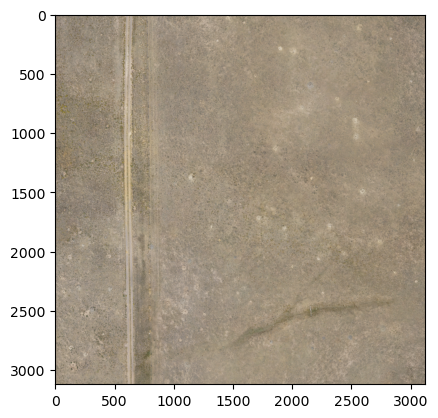

<AxesSubplot:>

In [75]:
show(image_dict['rgb'].astype('int'))

In [ ]:
show(rgb_xr_list[0].astype('int').values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [45]:
#rgb_xr_list[0].min()
rgb_xr_list = [x.where(x != 255) for x in rgb_xr_list if not x.where(x != 255).isnull().all().values]
rgb_null_ct = [x.isnull().sum().values.item() for x in rgb_xr_list]
rgb_xr_list = [rgb_xr_list[i] for i in np.argsort(rgb_null_ct)]
#rgb_xr_list[1].isnull().sum()
#rgb_xr_list[0].fillna(0).astype('int').values
#show(rgb_xr_list[1].astype('int').values)

In [48]:
rgb_null_ct

[276289770, 2]

In [41]:
list(np.argsort(rgb_null_ct))

[0, 1]

In [31]:
test = rgb_xr_list[0].where(rgb_xr_list[1].isnull(), drop=True)
test

<xarray.DataArray (band: 0, y: 0, x: 0)>
array([], shape=(0, 0, 0), dtype=float32)
Coordinates:
  * band         (band) int64 
  * x            (x) float64 
  * y            (y) float64 
    spatial_ref  int64 0
Attributes:
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  1812.683693159008,1945.1232612883,2097.202912864...
    STATISTICS_MAXIMUM:      255
    STATISTICS_MEAN:         164.21227088156
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       42.575623226901
    scale_factor:            1.0
    add_offset:              0.0

In [62]:

rgb_xr_list = []
for rgb_f in img_f_dict[pasture]['rgb']:
    with riox.open_rasterio(rgb_f, masked=True, cache=False) as rgb_src:
        rgb_xr_list.append(rgb_src.sel(band=slice(0, 3),
                                       x=slice(ll[0], lr[0]),
                                       y=slice(ul[1], ll[1]), 
                                       drop=True).load())

In [64]:
#rgb_xr_list

In [59]:
%time
rgb_xr_list = [x for x in rgb_xr_list if not any([s == 0 for s in x.shape])]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [65]:
%time
rgb_xr_list[1].where(rgb_xr_list[1] != 255).isnull().all().values

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.81 µs


array(False)

In [39]:
%time
rgb_xr_list = [x.where(x != 255, drop=True) for x in rgb_xr_list if not x.where(x != 255).isnull().all().values]

[<xarray.DataArray (band: 3, y: 2096, x: 10381)>
 dask.array<xarray-<this-array>, shape=(3, 2096, 10381), dtype=float32, chunksize=(3, 250, 250), chunktype=numpy.ndarray>
 Coordinates:
   * band         (band) int64 1 2 3
   * x            (x) float64 5.192e+05 5.192e+05 ... 5.193e+05 5.193e+05
   * y            (y) float64 4.518e+06 4.518e+06 ... 4.518e+06 4.518e+06
     spatial_ref  int64 0
 Attributes:
     RepresentationType:      ATHEMATIC
     STATISTICS_COVARIANCES:  1812.683693159008,1945.1232612883,2097.202912864...
     STATISTICS_MAXIMUM:      255
     STATISTICS_MEAN:         164.21227088156
     STATISTICS_MINIMUM:      0
     STATISTICS_SKIPFACTORX:  1
     STATISTICS_SKIPFACTORY:  1
     STATISTICS_STDDEV:       42.575623226901
     scale_factor:            1.0
     add_offset:              0.0
     _FillValue:              -9999.0,
 <xarray.DataArray (band: 3, y: 10598, x: 10598)>
 dask.array<xarray-<this-array>, shape=(3, 10598, 10598), dtype=float32, chunksize=(3, 250

In [ ]:
show(image_dict['rgb'])

In [ ]:
show(pr_mask)

<AxesSubplot:>

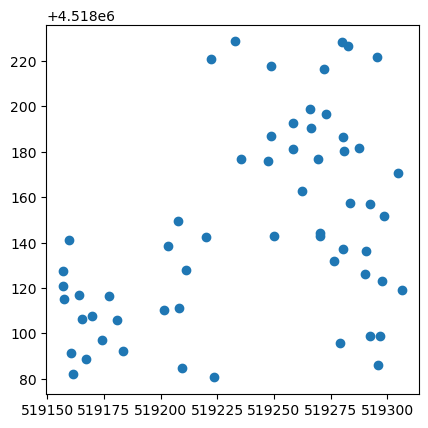

In [35]:
gdf_out.plot()